In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


# utils
import os
from tqdm.notebook import tqdm
from collections import Counter

# WordNet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

## Dataset

In [2]:
class IMDBDataset:
    def __init__(self, dataset_path):
        self.raw_df = pd.read_csv(dataset_path)

    def do_preprocessing(self):
        self.raw_df["sentiment"] = (self.raw_df["sentiment"] == "positive").astype(int)
        self.raw_df = self.__clean_text(self.raw_df, "review")
        self.raw_df["review"] = self.raw_df["review"].apply(self.__preprocess_text)

        return self.raw_df

    def __preprocess_text(self, text):
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        tokens = [t for t in tokens if t not in stopwords]

        return " ".join(tokens)

    def __clean_text(self, df, col_name):
        df[col_name] = df[col_name].apply(self.__remove_links)
        df[col_name] = df[col_name].apply(self.__remove_tags)
        df[col_name] = df[col_name].apply(self.__remove_extra_whitespace)
        df[col_name] = df[col_name].apply(self.__remove_numbers)
        df[col_name] = df[col_name].apply(self.__remove_punctuations)

        return df

    def __remove_punctuations(self, text):
        return re.sub(r"[^\w\s]", "", text)

    def __remove_links(self, text):
        return re.sub(r"http\S+|www\S+", "", text)

    def __remove_tags(self, text):
        return re.sub(r"<[^>]+>", "", text)

    def __remove_extra_whitespace(self, text):
        return re.sub(r"\s+", " ", text).strip()

    def __remove_numbers(self, text):
        return re.sub(r"\d+", "", text)

In [3]:
imdb_dataset = IMDBDataset(dataset_path="/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
preprocessed_df = imdb_dataset.do_preprocessing()
preprocessed_df.head()

,review,sentiment
0,One reviewer ha mentioned watching Oz episode ...,1
1,A wonderful little production The filming tech...,1
2,I thought wa wonderful way spend time hot summ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [4]:
def make_dictionary(preprocessed_df):
    all_words = ' '.join(preprocessed_df.review.values).split()
    counter = Counter(all_words)
    vocab = sorted(counter, key=counter.get, reverse=True)

    idx_to_token = dict(enumerate(vocab, 1))
    idx_to_token[0] = "<PADDING>"
    token_to_idx = {token: idx for idx, token in idx_to_token.items()}
    
    return idx_to_token, token_to_idx

def pad_sequence(sequence, seq_length):
    if len(sequence) >= seq_length:
        return sequence[:seq_length]
    else:
        padded_sequence = sequence + [0] * (seq_length - len(sequence))
        return padded_sequence

In [5]:
idx_to_token, token_to_idx = make_dictionary(preprocessed_df)
preprocessed_df["tokens"] = preprocessed_df["review"].apply(lambda x: [token_to_idx[token] for token in x.split()])

seq_length = 256
preprocessed_df["tokens"] = preprocessed_df["tokens"].apply(lambda x: pad_sequence(x, seq_length))

preprocessed_df.head()

,review,sentiment,tokens
0,One reviewer ha mentioned watching Oz episode ...,1,"[227, 1054, 8, 943, 81, 3772, 184, 439, 2971, ..."
1,A wonderful little production The filming tech...,1,"[60, 318, 55, 246, 5, 1242, 1613, 17848, 89094..."
2,I thought wa wonderful way spend time hot summ...,1,"[1, 101, 3, 318, 27, 1009, 9, 896, 1753, 2510,..."
3,Basically family little boy Jake think zombie ...,0,"[2724, 141, 55, 249, 3460, 34, 677, 4406, 593,..."
4,Petter Matteis Love Time Money visually stunni...,1,"[89098, 35004, 1123, 1977, 7469, 2188, 1279, 4..."


In [6]:
y = np.array(preprocessed_df["sentiment"].tolist())
X = np.array(preprocessed_df["tokens"].tolist())

train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_size = int(train_frac*len(X))
val_size = int(val_frac*len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("train split: ", X_train.shape, y_train.shape)
print("val split: ", X_val.shape, y_val.shape)
print("test split: ", X_test.shape, y_test.shape)

train split:  (35000, 256) (35000,)
val split:  (5000, 256) (5000,)
test split:  (10000, 256) (10000,)


## Model

In [7]:
from sklearn.metrics import accuracy_score
import time

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
num_epochs = 10
batch_size = 256
lr = 1e-3

vocab_size = len(idx_to_token)
embedding_size = 256
hidden_size = 512
n_layers = 2

In [29]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size=1,
        hidden_size=128,
        embedding_size=400,
        n_layers=2,
    ):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(
            embedding_size, hidden_size, n_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.embedding(x.long())
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [31]:
# works for both train and test
def run_epoch(
    model,
    optimizer,
    data_loader,
    criterion,
    device,
    results,
    score_funcs=None,
    prefix="",
    desc=None,
):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).float()

        y_hat = model(inputs)           
        loss = criterion(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Store metrics
        running_loss.append(loss.item())
        if score_funcs is None:
            score_funcs = {}
        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            # moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            # add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())

    end = time.time()
    
    y_pred = np.asarray(y_pred)
    y_pred = np.array([1 if i == True else 0 for i in y_pred > 0.5])

    results[prefix + " loss"].append(np.mean(running_loss))
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append(score_func(y_true, y_pred))
        except:
            results[prefix + " " + name].append(float("NaN"))
        
    return end - start

In [32]:
def train_network(
    model,
    criterion,
    train_loader,
    val_loader=None,
    test_loader=None,
    score_funcs=None,
    epochs=50,
    device="cpu",
    checkpoint_file=None,
    lr_scheduler=None,
    optimizer=None,
    disable_tqdm=False,
    log_items=(),
):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score)
            if val_loader is not None:
                to_track.append("val " + eval_score)
            if test_loader is not None:
                to_track.append("test " + eval_score)

    # Initialization
    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    if optimizer == None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)
    pbar = tqdm(range(epochs), desc="Epoch", disable=disable_tqdm)
    for epoch in pbar:
        model = model.train()

        total_train_time += run_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_loader,
            criterion=criterion,
            device=device,
            results=results,
            score_funcs=score_funcs,
            prefix="train",
            desc="Training",
        )

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)

        # Predict the validation set
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model=model,
                    optimizer=optimizer,
                    data_loader=val_loader,
                    criterion=criterion,
                    device=device,
                    results=results,
                    score_funcs=score_funcs,
                    prefix="val",
                    desc="Validating",
                )

        if lr_scheduler is not None:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(results["val loss"][-1])
            else:
                lr_scheduler.step()
        
        # Predict the validation set
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model=model,
                    optimizer=optimizer,
                    data_loader=test_loader,
                    criterion=criterion,
                    device=device,
                    results=results,
                    score_funcs=score_funcs,
                    prefix="test",
                    desc="Testing",
                )

        log_postfix = {}
        log_str = f"Epoch [{epoch+1}]: "
        for log_item in log_items:
            log_postfix[log_item] = results[log_item][-1]
            log_str += f"{log_item}: {results[log_item][-1]:.4f}, "

        pbar.set_postfix(log_postfix)
        print(log_str)

    if checkpoint_file is not None:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "results": results,
            },
            checkpoint_file,
        )

    return results

In [33]:
def test_network(
    model,
    optimizer,
    criterion,
    test_loader,
    score_funcs=None,
    device="cpu",
):
    to_track = ["total time", "test loss"]
    for eval_score in score_funcs:
        to_track.append("test " + eval_score)

    # Initialization
    total_test_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    model.to(device)
    model = model.eval()
    with torch.no_grad():
        total_test_time += run_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=test_loader,
            criterion=criterion,
            device=device,
            results=results,
            score_funcs=score_funcs,
            prefix="test",
            desc="Testing",
        )
        results["total time"].append(total_test_time)
    return results

In [34]:
model = LSTMModel(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    embedding_size=embedding_size,
    n_layers=n_layers,
)

# RNN based models are sensetive to gradient explode/vanishing
# so we add gradient clipping
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
score_funcs = {"acc": accuracy_score}

train_results = train_network(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    score_funcs=score_funcs,
    epochs=num_epochs,
    device=device,
    log_items=("train loss", "val loss", "train acc", "val acc"),
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1]: train loss: 0.6936, val loss: 0.6927, train acc: 0.5002, val acc: 0.4996, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2]: train loss: 0.6928, val loss: 0.6922, train acc: 0.5058, val acc: 0.4994, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3]: train loss: 0.6912, val loss: 0.6921, train acc: 0.5007, val acc: 0.5036, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4]: train loss: 0.6872, val loss: 0.6953, train acc: 0.5098, val acc: 0.5046, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5]: train loss: 0.6746, val loss: 0.7018, train acc: 0.5272, val acc: 0.5112, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6]: train loss: 0.6480, val loss: 0.7155, train acc: 0.5463, val acc: 0.5102, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7]: train loss: 0.5981, val loss: 0.5737, train acc: 0.6343, val acc: 0.7498, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8]: train loss: 0.4109, val loss: 0.4187, train acc: 0.8080, val acc: 0.8190, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9]: train loss: 0.2940, val loss: 0.4013, train acc: 0.8770, val acc: 0.8366, 


Training:   0%|          | 0/137 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10]: train loss: 0.2131, val loss: 0.3742, train acc: 0.9175, val acc: 0.8470, 


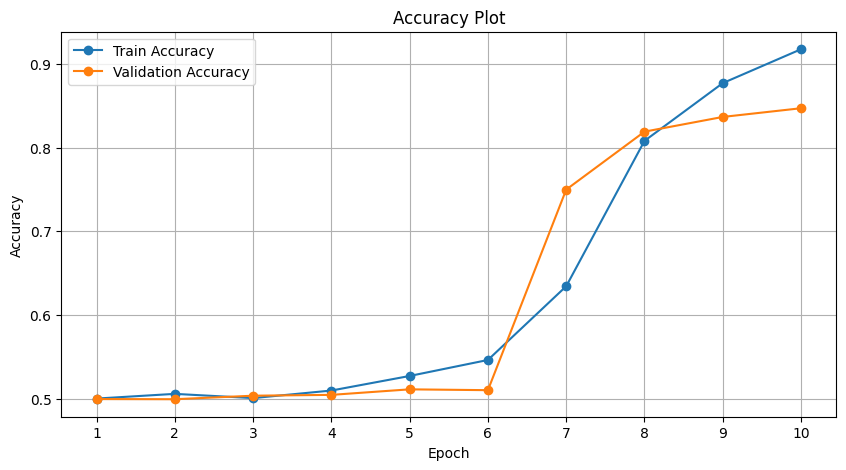

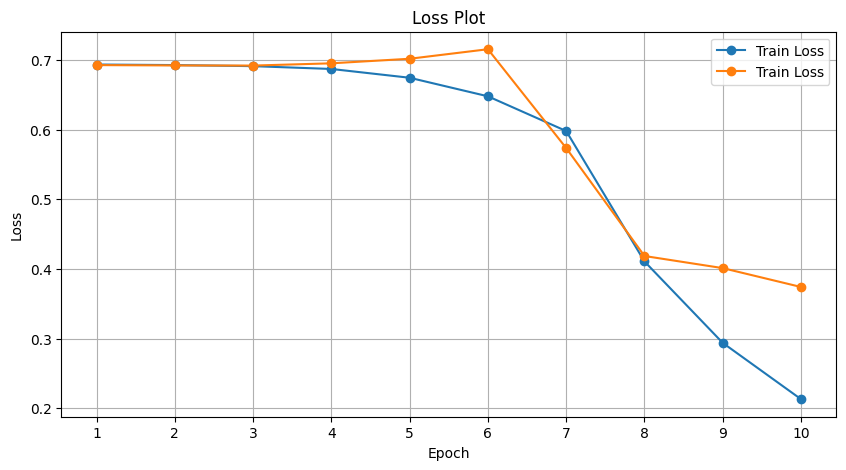

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1), train_results["train acc"], label="Train Accuracy", marker="o"
)
plt.plot(
    range(1, num_epochs + 1), train_results["val acc"], label="Validation Accuracy", marker="o"
)
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_results["train loss"], label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), train_results["val loss"], label="Train Loss", marker="o")
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [36]:
test_results = test_network(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    test_loader=test_loader,
    score_funcs=score_funcs,
    device=device,
)

print(f"test loss= {test_results['test loss'][-1]:.4f}, test accuracy= {test_results['test acc'][-1]:.4f}")


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

test loss= 0.4056, test accuracy= 0.8416
